<a href="https://colab.research.google.com/github/VedKate/Vedeneeva_Ekaterina_RT5/blob/main/BMSTU_TMO_2022/%D0%9B%D0%A0/%D0%9B%D0%A03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Подготовка обучающей и тестовой выборки, кросс-валидация и подбор гиперпараметров на примере метода ближайших соседей

Веденеева Е.И. РТ5-61Б

In [2]:
from IPython.display import Image
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris, load_boston
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import KFold, RepeatedKFold, LeaveOneOut, LeavePOut, ShuffleSplit, StratifiedKFold
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error, median_absolute_error, r2_score 
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import learning_curve, validation_curve
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
sns.set(style="ticks")

Для обучения по методу K ближайших соседей (KNN) был выбран датасет с классификацией типа звёзд c ресурса kaggle (Star Type Classification / NASA)

В данном наборе данных присутствуют следующие столбцы:

Temperature — температура звезды в Кельвинах;\
L (Luminosity) — светимость звезды в солнечных светимостях;\
R (Radius) — радиус звезды в радиусах солнца;\
A_M (Absolute Magnitude) — абсолютная звёздная величина;\
Color — цвет света звезды;\
Spectral_Class — спектральный класс звезды;\
Type — тип звезды. Является целевым признаком и уже закодирован:
* Красный карлик — 0;
* Коричневый карлик — 1;
* Белый карлик — 2;
* Звезда из главной последовательности — 3;
* Супергигант — 4;
* Гипергигант — 5.

**Загрузка данных**

In [3]:
# Загрузка датасета
data = pd.read_csv('Stars.csv')

#**Разведочный анализ**

In [4]:
# Первые пять строк датасета
data.head()

,Temperature,L,R,A_M,Color,Spectral_Class,Type
0,3068,0.002400,0.1700,16.12,Red,M,0
1,3042,0.000500,0.1542,16.60,Red,M,0
2,2600,0.000300,0.1020,18.70,Red,M,0
3,2800,0.000200,0.1600,16.65,Red,M,0
4,1939,0.000138,0.1030,20.06,Red,M,0


In [5]:
# Последние пять строк датасета
data.tail()


,Temperature,L,R,A_M,Color,Spectral_Class,Type
235,38940,374830.0,1356.0,-9.93,Blue,O,5
236,30839,834042.0,1194.0,-10.63,Blue,O,5
237,8829,537493.0,1423.0,-10.73,White,A,5
238,9235,404940.0,1112.0,-11.23,White,A,5
239,37882,294903.0,1783.0,-7.80,Blue,O,5


In [6]:
# Размер датасета
data.shape

(240, 7)

In [7]:
# Типы столбцов
data.dtypes

Temperature         int64
L                 float64
R                 float64
A_M               float64
Color              object
Spectral_Class     object
Type                int64
dtype: object

In [8]:
# Пустые значения
data.isnull().sum()

Temperature       0
L                 0
R                 0
A_M               0
Color             0
Spectral_Class    0
Type              0
dtype: int64

In [9]:
# Дублирующиеся значения
data.duplicated().sum()

0

In [10]:
# Статистические характеристки датасета
data.describe()

,Temperature,L,R,A_M,Type
count,240.000000,240.000000,240.000000,240.000000,240.000000
mean,10497.462500,107188.361635,237.157781,4.382396,2.500000
std,9552.425037,179432.244940,517.155763,10.532512,1.711394
min,1939.000000,0.000080,0.008400,-11.920000,0.000000
25%,3344.250000,0.000865,0.102750,-6.232500,1.000000
50%,5776.000000,0.070500,0.762500,8.313000,2.500000
75%,15055.500000,198050.000000,42.750000,13.697500,4.000000
max,40000.000000,849420.000000,1948.500000,20.060000,5.000000


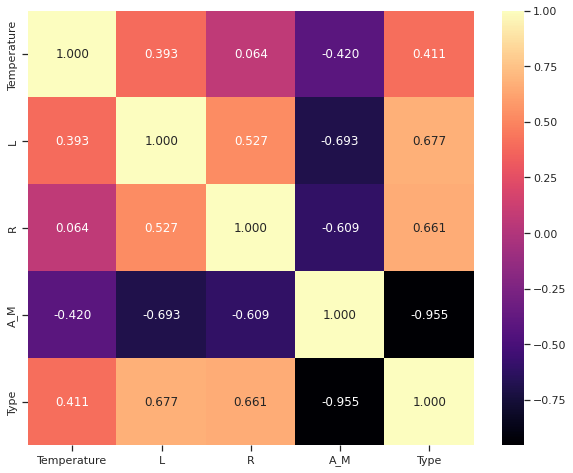

In [11]:
# Тепловая карта корреляционной матрицы
plt.figure(figsize=(10,8))
sns.heatmap(data=data.corr(), annot=True, fmt='.3f', cmap='magma')
plt.show()

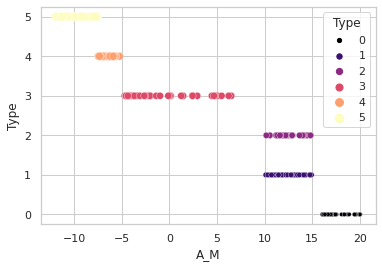

In [12]:
# Диаграмма рассеивания абсолютной звёздной величины и типа звезды
with sns.axes_style('whitegrid'):
    sns.scatterplot(data=data, x='A_M', y='Type', hue='Type', size='Type', palette='magma')
    plt.show()

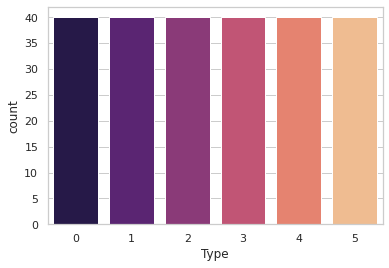

In [13]:
# График распределения типов звёзд
with sns.axes_style('whitegrid'):
    sns.countplot(data=data, x='Type', palette='magma')
    plt.show()

# **Обработка данных**

In [14]:
# Значение в столбце Color
data['Color'].value_counts()

Red                   112
Blue                   56
Blue-white             26
Blue White             10
yellow-white            8
White                   7
Blue white              4
white                   3
Yellowish White         3
yellowish               2
Whitish                 2
Orange                  2
White-Yellow            1
Pale yellow orange      1
Yellowish               1
Orange-Red              1
Blue-White              1
Name: Color, dtype: int64

Как видно из таблице у нас есть часть значений, которые по факту являются одним и тем же. Например, White и white.

Обработаем данные значения

In [15]:
colors = ['Blue-white', 'Blue White', 'Blue white', 'yellow-white', 'Yellowish White', 'yellowish', 'Yellowish', 'White-Yellow',
          'white', 'Whitish', 'Pale yellow orange', 'Orange-Red']

# Замена цветов
for i in range(len(data['Color'])):
    if data['Color'][i] in colors [:3]:
        data.loc[i, 'Color'] = 'Blue-White'
    elif data['Color'][i] in colors [3:8]:
        data.loc[i, 'Color'] = 'Yellow-White'
    elif data['Color'][i] in colors [8:10]:
        data.loc[i, 'Color'] = 'White'
    elif data['Color'][i] in colors [10:]:
        data.loc[i, 'Color'] = 'Orange'

In [16]:
# Проверка замены цветов
data['Color'].value_counts()

Red             112
Blue             56
Blue-White       41
Yellow-White     15
White            12
Orange            4
Name: Color, dtype: int64

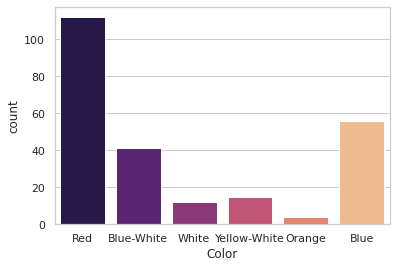

In [17]:
# График количества цветов
with sns.axes_style('whitegrid'):
    sns.countplot(data=data, x='Color', palette='magma')
    plt.show()


**Кодирование категориальных признаков**

In [18]:
# One-hot кодирование признаков Color и Spectral_Class, поскольку нам не нужно вность отношение порядка
data_encoded = pd.get_dummies(data, columns=['Color', 'Spectral_Class'])

data_encoded.head()

,Temperature,L,R,A_M,Type,Color_Blue,Color_Blue-White,Color_Orange,Color_Red,Color_White,Color_Yellow-White,Spectral_Class_A,Spectral_Class_B,Spectral_Class_F,Spectral_Class_G,Spectral_Class_K,Spectral_Class_M,Spectral_Class_O
0,3068,0.002400,0.1700,16.12,0,0,0,0,1,0,0,0,0,0,0,0,1,0
1,3042,0.000500,0.1542,16.60,0,0,0,0,1,0,0,0,0,0,0,0,1,0
2,2600,0.000300,0.1020,18.70,0,0,0,0,1,0,0,0,0,0,0,0,1,0
3,2800,0.000200,0.1600,16.65,0,0,0,0,1,0,0,0,0,0,0,0,1,0
4,1939,0.000138,0.1030,20.06,0,0,0,0,1,0,0,0,0,0,0,0,1,0


**Масштабирование данных**

In [19]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(data_encoded.drop(columns=['Type']))

In [20]:
# Вставка отмасштабированных данных
data_scaled = pd.DataFrame(scaled_features, columns=data_encoded.columns[:-1])

data_scaled.head()

,Temperature,L,R,A_M,Type,Color_Blue,Color_Blue-White,Color_Orange,Color_Red,Color_White,Color_Yellow-White,Spectral_Class_A,Spectral_Class_B,Spectral_Class_F,Spectral_Class_G,Spectral_Class_K,Spectral_Class_M
0,-0.779382,-0.598624,-0.459210,1.116745,-0.551677,-0.453905,-0.130189,1.069045,-0.229416,-0.258199,-0.293211,-0.486943,-0.276104,-0.064685,-0.160128,1.078036,-0.447214
1,-0.782110,-0.598624,-0.459241,1.162414,-0.551677,-0.453905,-0.130189,1.069045,-0.229416,-0.258199,-0.293211,-0.486943,-0.276104,-0.064685,-0.160128,1.078036,-0.447214
2,-0.828477,-0.598624,-0.459342,1.362213,-0.551677,-0.453905,-0.130189,1.069045,-0.229416,-0.258199,-0.293211,-0.486943,-0.276104,-0.064685,-0.160128,1.078036,-0.447214
3,-0.807496,-0.598624,-0.459229,1.167171,-0.551677,-0.453905,-0.130189,1.069045,-0.229416,-0.258199,-0.293211,-0.486943,-0.276104,-0.064685,-0.160128,1.078036,-0.447214
4,-0.897819,-0.598624,-0.459340,1.491607,-0.551677,-0.453905,-0.130189,1.069045,-0.229416,-0.258199,-0.293211,-0.486943,-0.276104,-0.064685,-0.160128,1.078036,-0.447214


# **Обучение и метрики**

In [21]:
X = data_scaled
y = data_encoded['Type']
y_features_name = ['Red Dwarf', 'Brown Dwarf', 'White Dwarf', 'Main Sequence', 'Super Giant', 'Hyper Giant']

X_train : pd.DataFrame
X_test : pd.DataFrame
y_train : pd.Series
y_test : pd.Series

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3)

In [22]:
# Размер обучающей выборки
X_train.shape, y_train.shape

((192, 17), (192,))

In [23]:
# Размер тестовой выборки
X_test.shape, y_test.shape

((48, 17), (48,))

In [24]:
# Обучение модели (K = 5 — значение по умолчанию)
knn_classifier = KNeighborsClassifier()
knn_classifier.fit(X_train, y_train)

KNeighborsClassifier()

In [25]:
# Предсказания обученной модели на тестовой выборке
knn_classifier_prediction = knn_classifier.predict(X_test)

In [26]:
# Метрика accuracy
accuracy_score(y_test, knn_classifier_prediction)

0.9791666666666666

In [27]:
# Матрица ошибок
cm = confusion_matrix(y_test, knn_classifier_prediction)
cm

array([[ 9,  0,  0,  0,  0,  0],
       [ 0, 11,  0,  0,  0,  0],
       [ 0,  0,  7,  0,  0,  0],
       [ 0,  0,  0,  7,  0,  0],
       [ 0,  0,  0,  0,  9,  0],
       [ 0,  0,  1,  0,  0,  4]])

In [28]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

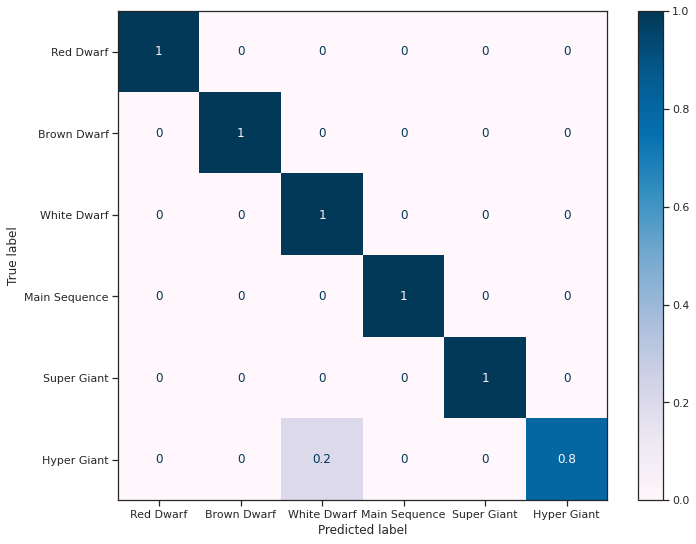

In [29]:
# Тепловая карта нормализованной матрицы ошибок
cm_normalized = confusion_matrix(y_test, knn_classifier_prediction, normalize='true')

_, ax = plt.subplots(figsize=(11, 9))
cm_norm_display = ConfusionMatrixDisplay(cm_normalized, display_labels=y_features_name)
cm_norm_display.plot(cmap='PuBu', ax=ax)
plt.show()

**Точность (precision), полнота (recall) и F-мера (F1)**

In [30]:
print('Precission: {};'.format(precision_score(y_test, knn_classifier_prediction, average='weighted')))
print('Recall: {};'.format(recall_score(y_test, knn_classifier_prediction, average='weighted')))
print('F1 score: {};'.format(f1_score(y_test, knn_classifier_prediction, average='weighted')))

Precission: 0.9817708333333334;
Recall: 0.9791666666666666;
F1 score: 0.9787037037037036;


#**Оценка качества модели c использованием кросс-валидации**

In [31]:
# Метрики, которые будут использоваться при оценки качества модели
scoring = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted']

**1. k-fold**

In [32]:
# Оценка качества модели через стратегию K-Fold
scores = cross_val_score(KNeighborsClassifier(), X, y, cv=KFold(n_splits=10), scoring='f1_weighted')
print('{}\nMean: {}'.format(scores, np.mean(scores)))

[1.         0.34541063 0.97222222 0.95883941 0.89844055 1.
 0.95743146 0.84444444 1.         0.69230769]
Mean: 0.8669096396441933


In [33]:
# Оценка качества модели через стратегию K-Fold с помощью метода cross_validate
# Разбиения всего два, так как при большем их количестве возникают предупреждения UndefinedMetricWarning
cross_validate(KNeighborsClassifier(), X, y, cv=KFold(n_splits=2), scoring=scoring, return_train_score=True)

{'fit_time': array([0.00483346, 0.00331545]),
 'score_time': array([0.0203681 , 0.01178765]),
 'test_accuracy': array([0.73333333, 0.74166667]),
 'test_f1_weighted': array([0.72988875, 0.70475669]),
 'test_precision_weighted': array([0.82700922, 0.80780423]),
 'test_recall_weighted': array([0.73333333, 0.74166667]),
 'train_accuracy': array([0.95833333, 0.91666667]),
 'train_f1_weighted': array([0.95820989, 0.9158622 ]),
 'train_precision_weighted': array([0.96139971, 0.91678692]),
 'train_recall_weighted': array([0.95833333, 0.91666667])}

**2.  Stratified K-Fold**

In [43]:
# Оценка качества модели через стратегию Stratified K-Fold
scores = cross_val_score(KNeighborsClassifier(), X, y, cv=StratifiedKFold(n_splits=10), scoring='f1_weighted')
print('{}\nMean: {}'.format(scores, np.mean(scores)))

[0.95767196 0.82222222 0.82777778 0.95767196 0.91904762 0.95767196
 0.91534392 0.91111111 1.         0.91111111]
Mean: 0.9179629629629631


In [44]:
# Оценка качества модели через стратегию Stratified K-Fold с помощью метода cross_validate
# Разбиения всего два, так как при большем их количестве возникают предупреждения UndefinedMetricWarning
cross_validate(KNeighborsClassifier(), X, y, cv=StratifiedKFold(n_splits=2), scoring=scoring, return_train_score=True)

{'fit_time': array([0.00805616, 0.00998688]),
 'score_time': array([0.03057456, 0.02573729]),
 'test_accuracy': array([0.73333333, 0.74166667]),
 'test_f1_weighted': array([0.72988875, 0.70475669]),
 'test_precision_weighted': array([0.82700922, 0.80780423]),
 'test_recall_weighted': array([0.73333333, 0.74166667]),
 'train_accuracy': array([0.95833333, 0.91666667]),
 'train_f1_weighted': array([0.95820989, 0.9158622 ]),
 'train_precision_weighted': array([0.96139971, 0.91678692]),
 'train_recall_weighted': array([0.95833333, 0.91666667])}

**3. ShuffleSplit**

In [45]:
# Оценка качества модели через стратегию ShuffleSplit
scores = cross_val_score(KNeighborsClassifier(), X, y, cv=ShuffleSplit(n_splits=10, test_size=0.25, random_state=10), scoring='f1_weighted')
print('{}\nMean: {}'.format(scores, np.mean(scores)))

[0.91860535 0.98375758 0.95069444 0.89780659 0.86564111 0.89916226
 0.93485265 0.9198061  0.91638173 0.84563188]
Mean: 0.9132339690013443


# **Подбор гиперпараметра K**

Для подбора гиперпараметра K будем использовать следующие стратегии кросс-валидации: K-Fold, Stratified K-Fold, ShuffleSplit. Оптимизировать будем по взешенной F1-мере

In [46]:
# Диапазон гиперпараметра K для оптимизации
n_range = np.array(range(1, 21, 1))
parameters_to_tune = [{'n_neighbors' : n_range}]
parameters_to_tune

[{'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
         18, 19, 20])}]

## 1. Решетчатый поиск

### 1.1 K-fold

In [47]:
#%%time
# Решетчатый поиск со стратегией K-Fold
clf_gs_k_fold= GridSearchCV(KNeighborsClassifier(), parameters_to_tune, cv=KFold(n_splits=10), scoring='f1_weighted')
clf_gs_k_fold.fit(X, y)

GridSearchCV(cv=KFold(n_splits=10, random_state=None, shuffle=False),
             estimator=KNeighborsClassifier(),
             param_grid=[{'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20])}],
             scoring='f1_weighted')

In [48]:
# Лучшее значение гиперпараметра
clf_gs_k_fold.best_params_

{'n_neighbors': 1}

In [49]:
# Лучшее значение метрики
clf_gs_k_fold.best_score_

0.941294773194928

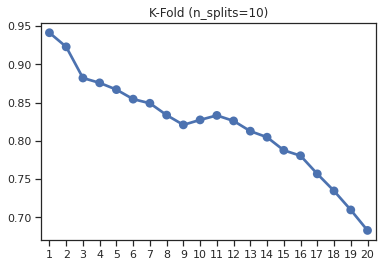

In [50]:
# Изменение качества на тестовой выборке в зависимости от значения гиперпараметра K
sns.pointplot(x=n_range, y=clf_gs_k_fold.cv_results_['mean_test_score'])
plt.title('K-Fold (n_splits=10)')
plt.show()

### 1.2. Stratified K-Fold

In [51]:
#%%time
# Решетчатый поиск со стратегией Stratified K-Fold
clf_gs_s_k_fold = GridSearchCV(KNeighborsClassifier(), parameters_to_tune, cv=StratifiedKFold(n_splits=10), scoring='f1_weighted')
clf_gs_s_k_fold.fit(X, y)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
             estimator=KNeighborsClassifier(),
             param_grid=[{'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20])}],
             scoring='f1_weighted')

In [52]:
# Лучшее значение гиперпараметра
clf_gs_s_k_fold.best_params_

{'n_neighbors': 3}

In [53]:
# Лучшее значение метрики
clf_gs_s_k_fold.best_score_

0.9404365079365078

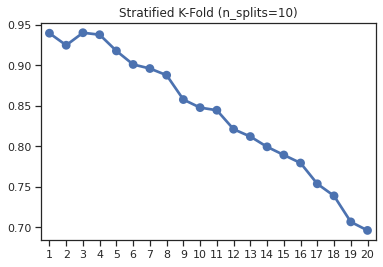

In [54]:
# Изменение качества на тестовой выборке в зависимости от значения гиперпараметра K
sns.pointplot(x=n_range, y=clf_gs_s_k_fold.cv_results_['mean_test_score'])
plt.title('Stratified K-Fold (n_splits=10)')
plt.show()

### 1.3 ShuffleSplit

In [74]:
#%%time
# Решетчатый поиск со стратегией Stratified ShuffleSplit
clf_gs_sfl_splt = GridSearchCV(KNeighborsClassifier(), parameters_to_tune, cv=ShuffleSplit(n_splits=10, test_size=0.25, random_state=10),
                                   scoring='f1_weighted')
clf_gs_sfl_splt.fit(X, y)

GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=10, test_size=0.25, train_size=None),
             estimator=KNeighborsClassifier(),
             param_grid=[{'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20])}],
             scoring='f1_weighted')

In [75]:
# Лучшее значение гиперпараметра
clf_gs_sfl_splt.best_params_

{'n_neighbors': 1}

In [76]:
# Лучшее значение метрики
clf_gs_sfl_splt.best_score_

0.9521177553842886

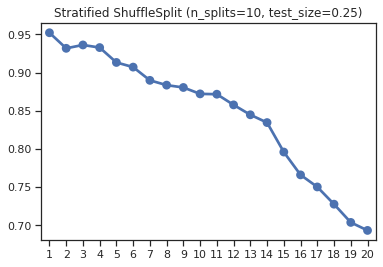

In [77]:
# Изменение качества на тестовой выборке в зависимости от значения гиперпараметра K
sns.pointplot(x=n_range, y=clf_gs_sfl_splt.cv_results_['mean_test_score'])
plt.title('Stratified ShuffleSplit (n_splits=10, test_size=0.25)')
plt.show()

## 2. Случайный поиск

### 2.1 K-Fokd

In [60]:
#%%time
# Случайный поиск со стратегией K-Fold
clf_rs_k_fold= RandomizedSearchCV(KNeighborsClassifier(), parameters_to_tune, cv=KFold(n_splits=10), scoring='f1_weighted', n_iter=20)
clf_rs_k_fold.fit(X, y)

RandomizedSearchCV(cv=KFold(n_splits=10, random_state=None, shuffle=False),
                   estimator=KNeighborsClassifier(), n_iter=20,
                   param_distributions=[{'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20])}],
                   scoring='f1_weighted')

In [61]:
# Лучшее значение гиперпараметра
clf_rs_k_fold.best_params_

{'n_neighbors': 1}

In [62]:
# Лучшее значение метрики
clf_rs_k_fold.best_score_

0.941294773194928

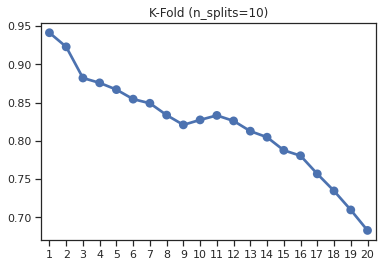

In [63]:
# Изменение качества на тестовой выборке в зависимости от значения гиперпараметра K
sns.pointplot(x=n_range, y=clf_rs_k_fold.cv_results_['mean_test_score'])
plt.title('K-Fold (n_splits=10)')
plt.show()

### 2.2 Stratified K-Fold

In [64]:
#%%time
# Случайный поиск со стратегией Stratified K-Fold
clf_rs_s_k_fold = RandomizedSearchCV(KNeighborsClassifier(), parameters_to_tune, cv=StratifiedKFold(n_splits=10),
                                     scoring='f1_weighted', n_iter=20)
clf_rs_s_k_fold.fit(X, y)


RandomizedSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
                   estimator=KNeighborsClassifier(), n_iter=20,
                   param_distributions=[{'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20])}],
                   scoring='f1_weighted')

In [65]:
# Лучшее значение гиперпараметра
clf_rs_s_k_fold.best_params_

{'n_neighbors': 3}

In [66]:
# Лучшее значение метрики
clf_rs_s_k_fold.best_score_

0.9404365079365078

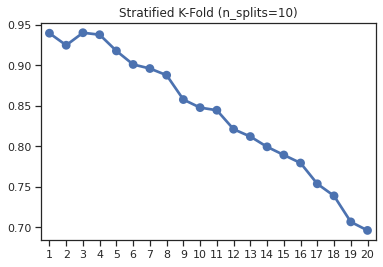

In [67]:
# Изменение качества на тестовой выборке в зависимости от значения гиперпараметра K
sns.pointplot(x=n_range, y=clf_rs_s_k_fold.cv_results_['mean_test_score'])
plt.title('Stratified K-Fold (n_splits=10)')
plt.show()

### 2.3 ShuffleSplit

In [69]:
#%%time
# Случайный поиск со стратегией Stratified ShuffleSplit
clf_rs_s_sfl_splt = RandomizedSearchCV(KNeighborsClassifier(), parameters_to_tune, cv=ShuffleSplit(n_splits=10, test_size=0.25, random_state=10),
                                     scoring='f1_weighted', n_iter=20)
clf_rs_s_sfl_splt.fit(X, y)

RandomizedSearchCV(cv=ShuffleSplit(n_splits=10, random_state=10, test_size=0.25, train_size=None),
                   estimator=KNeighborsClassifier(), n_iter=20,
                   param_distributions=[{'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20])}],
                   scoring='f1_weighted')

In [70]:
# Лучшее значение гиперпараметра
clf_rs_s_sfl_splt.best_params_

{'n_neighbors': 1}

In [71]:
# Лучшее значение метрики
clf_rs_s_sfl_splt.best_score_

0.9521177553842886

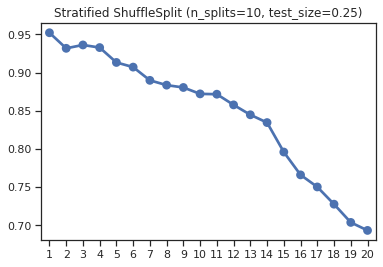

In [72]:
# Изменение качества на тестовой выборке в зависимости от значения гиперпараметра K
sns.pointplot(x=n_range, y=clf_rs_s_sfl_splt.cv_results_['mean_test_score'])
plt.title('Stratified ShuffleSplit (n_splits=10, test_size=0.25)')
plt.show()

# Обучение модели с оптимизированным гиперпараметром

В качестве оптимизированной модели возмём классификатор с гиперапараметром K = 1, найденным решетчатым поиском со стратегией ShuffleSplit, так как у него наиулчшее значение метрики.

In [78]:
# Обучение модели c оптимизированным гиперпараметром
knn_classifier_optimized = clf_gs_sfl_splt.best_estimator_
knn_classifier_optimized.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=1)

In [79]:
# Предсказания обученной модели на тестовой выборке
knn_classifier_optimized_prediction = knn_classifier_optimized.predict(X_test)
knn_classifier_optimized_prob = knn_classifier_optimized.predict_proba(X_test)

## Оценка качества модели с оптимизированным гиперпараметром

###  1. Accuracy

In [80]:
# Точности (Accuracies) старой и новой моделей
print('K = 5: {};\nK = 1: {}.'.format(accuracy_score(y_test, knn_classifier_prediction),
                                      accuracy_score(y_test, knn_classifier_optimized_prediction)))

K = 5: 0.9791666666666666;
K = 1: 1.0.


### 2. Матрицы ошибок

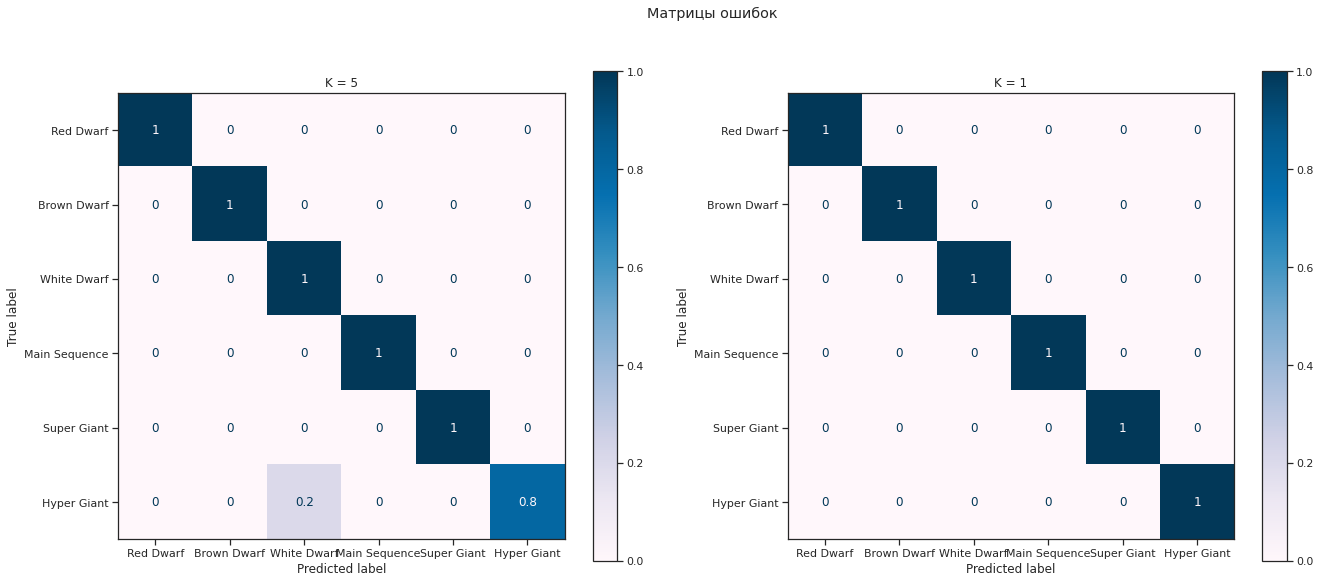

In [82]:
# Тепловые карты матриц ошибок
fig, ax = plt.subplots(1, 2, figsize=(22,9))
ConfusionMatrixDisplay.from_predictions(y_test, knn_classifier_prediction, normalize='true',
                                        display_labels=y_features_name, ax=ax[0], cmap='PuBu')
ConfusionMatrixDisplay.from_predictions(y_test, knn_classifier_optimized_prediction, normalize='true',
                                        display_labels=y_features_name, ax=ax[1], cmap='PuBu')
fig.suptitle('Матрицы ошибок')
ax[0].title.set_text('K = 5')
ax[1].title.set_text('K = 1')
plt.show()

### 3. Точность (precision), полнота (recall) и F-мера (F1)

In [83]:
# Точности (Precissions) старой и новой моделей (взвешенные)
print('K = 5: {};\nK = 1: {}.'.format(precision_score(y_test, knn_classifier_prediction, average='weighted'),
                                      precision_score(y_test, knn_classifier_optimized_prediction, average='weighted')))

K = 5: 0.9817708333333334;
K = 1: 1.0.


In [84]:
# Полноты (Recalls) старой и новой моделей (взвешенные)
print('K = 5: {};\nK = 1: {}.'.format(recall_score(y_test, knn_classifier_prediction, average='weighted'),
                                      recall_score(y_test, knn_classifier_optimized_prediction, average='weighted')))

K = 5: 0.9791666666666666;
K = 1: 1.0.


In [85]:
# F-меры (F1) старой и новой моделей (взвешенные)
print('K = 5: {};\nK = 1: {}.'.format(f1_score(y_test, knn_classifier_prediction, average='weighted'),
                                      f1_score(y_test, knn_classifier_optimized_prediction, average='weighted')))

K = 5: 0.9787037037037036;
K = 1: 1.0.


# Кривые обучения и валидации

In [86]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5), scoring='accuracy'):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel(scoring)
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, scoring=scoring, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.3,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

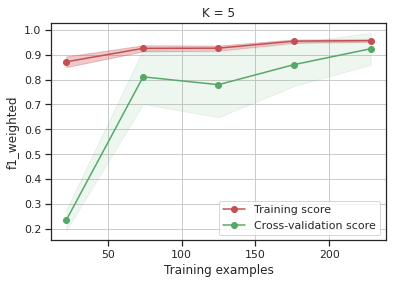

In [87]:
# Кривая обучения для первоначальной модели
plot_learning_curve(KNeighborsClassifier(), 'K = 5', X, y, cv=20, scoring='f1_weighted')
plt.show()

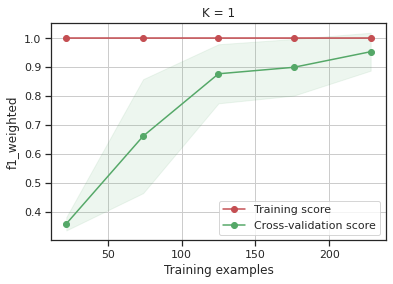

In [89]:
# Кривая обучения для модели с оптимизированным гиперпараметром
plot_learning_curve(clf_gs_sfl_splt.best_estimator_, 'K = 1', X, y, cv=20, scoring='f1_weighted')
plt.show()

In [90]:
def plot_validation_curve(estimator, title, X, y,
                          param_name, param_range, cv,
                          scoring='accuracy'):

    train_scores, test_scores = validation_curve(
        estimator, X, y, param_name=param_name, param_range=param_range,
        cv=cv, scoring=scoring, n_jobs=1)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.title(title)
    plt.xlabel(param_name)
    plt.ylabel(str(scoring))
    plt.ylim(0.0, 1.1)
    lw = 2
    plt.plot(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
    plt.fill_between(param_range, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.4,
                     color="darkorange", lw=lw)
    plt.plot(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
    plt.fill_between(param_range, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.2,
                     color="navy", lw=lw)
    plt.legend(loc="best")
    return plt

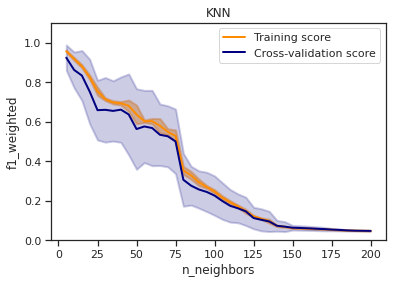

In [92]:
# Кривая валидации
n_range_for_val_curve = np.array(range(5,205,5))
plot_validation_curve(clf_gs_sfl_splt.best_estimator_, 'KNN',X, y,
                      param_name='n_neighbors', param_range=n_range_for_val_curve,
                      cv=20, scoring="f1_weighted")
plt.show()